In [1]:
import keras
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from sklearn.model_selection import StratifiedKFold
#from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as metrics
#from keras.models import Sequential
#from keras.layers import Dense, Conv2D, Flatten
import tensorflow as tf
import random
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
import pickle
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras import backend as K

Using TensorFlow backend.


In [2]:
dir_train_images  = './training/'
dir_test_images   = './testing/'
dir_train_labels  = './labels_training.csv'
dir_test_ids      = './sample_submission.csv'

In [3]:
def load_data(dir_data, dir_labels, training=True):
    ''' Load each of the image files into memory 

    While this is feasible with a smaller dataset, for larger datasets,
    not all the images would be able to be loaded into memory

    When training=True, the labels are also loaded
    '''
    labels_pd = pd.read_csv(dir_labels)
    ids       = labels_pd.id.values
    data      = []
    for identifier in ids:
        fname     = dir_data + identifier.astype(str) + '.tif'
        image     = mpl.image.imread(fname)
        data.append(image)
    data = np.array(data) # Convert to Numpy array
    if training:
        labels = labels_pd.label.values
        return data, labels
    else:
        return data, ids

In [4]:
def plot_roc(labels, prediction_scores):
    fpr, tpr, _ = metrics.roc_curve(labels, prediction_scores, pos_label=1)
    auc = metrics.roc_auc_score(labels, prediction_scores)
    legend_string = 'AUC = {:0.3f}'.format(auc)
   
    plt.plot([0,1],[0,1],'--', color='gray', label='Chance')
    plt.plot(fpr, tpr, label=legend_string)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid('on')
    plt.axis('square')
    plt.legend()
    plt.tight_layout()

In [5]:
X_train, y_train = load_data(dir_train_images, dir_train_labels, training=True)
X_train =(X_train)/255

In [6]:
from sklearn.model_selection import train_test_split
X_training, X_test, y_training, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=23)

X_training = X_training.reshape(-1,101,101,3)
X_test = X_test.reshape(-1,101,101,3)
y_training = keras.utils.to_categorical(y_training, num_classes = 2)
y_test = keras.utils.to_categorical(y_test, num_classes = 2)
X_training = X_training.astype('float32').copy()
X_test = X_test.astype('float32').copy()

In [70]:
inputShape = (101, 101, 3)

model1 = Sequential()
model1.add(Conv2D(20, (3,3), padding="same",
                 input_shape=inputShape))
model1.add(Activation("relu"))
model1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model1.add(Dropout(0.25))
#=============================================
model1.add(Conv2D(50, (2, 2), padding="same"))
model1.add(Activation("relu"))
model1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model1.add(Dropout(0.25))
#===============================================
model1.add(Conv2D(120, (2, 2), padding="same"))
model1.add(Activation("relu"))
model1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model1.add(Dropout(0.25))
#===============================================
model1.add(Conv2D(300, (2, 2), padding="same"))
model1.add(Activation("relu"))
model1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model1.add(Dropout(0.25))
#===============================================
model1.add(Conv2D(360, (2, 2), padding="same"))
model1.add(Activation("relu"))
model1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model1.add(Dropout(0.25))
#===============================================
#model1.add(Conv2D(400, (1, 1), padding="same"))
#model1.add(Activation("relu"))
#model1.add(MaxPooling2D(pool_size=(1, 1), strides=(1, 1)))
#model1.add(Dropout(0.25))
#===============================================
#model1.add(Conv2D(430, (1, 1), padding="same"))
#model1.add(Activation("relu"))
#model1.add(MaxPooling2D(pool_size=(1, 1), strides=(1, 1)))
#model1.add(Dropout(0.25))
#===============================================
#model1.add(Conv2D(450, (1, 1), padding="same"))
#model1.add(Activation("relu"))
#model1.add(MaxPooling2D(pool_size=(1, 1), strides=(1, 1)))
#model1.add(Dropout(0.25))

#===============================================
# first (and only) set of FC => RELU layers
model1.add(Flatten())
model1.add(Dense(3))
#model1.add(Activation("relu"))
#model1.add(Dense(2))
#model1.add(Activation("relu"))
# softmax classifier
model1.add(Dense(2))
model1.add(Activation("softmax"))

In [51]:
class_weight = {0: 1.,
                1: 2,}

In [57]:
EPOCHS = 1000
opt = Adam(lr=0.0006, decay=0.003 / (EPOCHS))
model1.compile(loss="binary_crossentropy", optimizer=opt,
              metrics=["accuracy"])

In [58]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 101, 101, 20)      560       
_________________________________________________________________
activation_31 (Activation)   (None, 101, 101, 20)      0         
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 50, 50, 20)        0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 50, 50, 20)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 50, 50, 50)        4050      
_________________________________________________________________
activation_32 (Activation)   (None, 50, 50, 50)        0         
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 25, 25, 50)        0         
__________

In [59]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=360, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.1, zoom_range=0.2,
                         horizontal_flip=True,vertical_flip =True,  fill_mode="nearest")

In [60]:
BS =35 # batch size
# train the neural network  (time consuming....)
print("[INFO] training network...")
H = model1.fit_generator(aug.flow(X_training, y_training, batch_size=BS),
                         validation_data=(X_test, y_test), steps_per_epoch=len(X_training) // BS,
                         epochs=EPOCHS, verbose=1, class_weight = class_weight)

[INFO] training network...
Epoch 1/1000
30/30 [==============================] - 24s 796ms/step - loss: 0.9193 - acc: 0.4733 - val_loss: 0.6739 - val_acc: 0.6644
Epoch 2/1000
30/30 [==============================] - 22s 725ms/step - loss: 0.9165 - acc: 0.5238 - val_loss: 0.6699 - val_acc: 0.6644
Epoch 3/1000
30/30 [==============================] - 23s 759ms/step - loss: 0.9125 - acc: 0.5057 - val_loss: 0.6637 - val_acc: 0.6644
Epoch 4/1000
30/30 [==============================] - 22s 737ms/step - loss: 0.9090 - acc: 0.4790 - val_loss: 0.6570 - val_acc: 0.6644
Epoch 5/1000
30/30 [==============================] - 22s 719ms/step - loss: 0.9023 - acc: 0.6076 - val_loss: 0.6510 - val_acc: 0.6644
Epoch 6/1000
30/30 [==============================] - 21s 696ms/step - loss: 0.8914 - acc: 0.5571 - val_loss: 0.6371 - val_acc: 0.6644
Epoch 7/1000
30/30 [==============================] - 21s 710ms/step - loss: 0.8748 - acc: 0.5924 - val_loss: 0.6231 - val_acc: 0.6644
Epoch 8/1000
30/30 [========

In [61]:
# save the model to disk
print("[INFO] serializing network...")
filename = 'cnn_5d_1000e_6e4.sav'
pickle.dump(model1, open(filename, 'wb'))

[INFO] serializing network...


In [22]:
#filename = 'cnn_3d_500e_1e3.sav'
filename = 'cnn_5d_300e_6e4.sav'
loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.predict(X_test)
#print(result)

In [8]:
X_train1 = X_train.reshape(-1,101,101,3)

y_train1 = keras.utils.to_categorical(y_train, num_classes = 2)

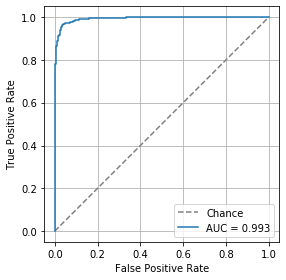

In [24]:
### test and validate model performance before submission
score=loaded_model.predict(X_training).ravel()
plot_roc(y_training.ravel(), score)

In [36]:
# save the model to disk
print("[INFO] serializing network...")
filename = 'cnn_model_gen.sav'
pickle.dump(model1, open(filename, 'wb'))

[INFO] serializing network...


In [69]:
####### Submission code here ############
test_data, ids = load_data(dir_test_images, dir_test_ids, training=False)
#test_features  = preprocess_and_extract_features(test_data)
test_data =(test_data)/255

test_data = test_data.reshape(-1,101,101,3)
test_data = test_data.astype('float32').copy()


test_scores    = loaded_model.predict_proba(test_data)[:,1]

    # Save the predictions to a CSV file for upload to Kaggle
submission_file = pd.DataFrame({'id':    ids,
                                   'score':  test_scores})
submission_file.to_csv('submission_cnn.csv',
                           columns=['id','score'],
                           index=False)

In [ ]:


from PIL import Image
from matplotlib import pyplot
# load image
image = Image.open('opera_house.jpg')
# horizontal flip
hoz_flip = image.transpose(Image.FLIP_LEFT_RIGHT)
# vertical flip
ver_flip = image.transpose(Image.FLIP_TOP_BOTTOM)

In [ ]:
from PIL import Image
# load the image
image = Image.open('opera_house.jpg')
# save as PNG format
image.save('opera_house.png', format='PNG')
# load the image again and inspect the format
image2 = Image.open('opera_house.png')
print(image2.format)

In [ ]:
from PIL import Image
# load the image
image = Image.open('opera_house.jpg')
# convert the image to grayscale
gs_image = image.convert(mode='L')
# save in jpeg format
gs_image.save('opera_house_grayscale.jpg')
# load the image again and show it
image2 = Image.open('opera_house_grayscale.jpg')
# show the image
image2.show()